<a href="https://colab.research.google.com/github/kanchangiri67/OncoCist/blob/main/PSD_Group_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 1: Get data

In [33]:
import scipy.io
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import h5py

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Website the dataset was retrieved from:

https://figshare.com/articles/dataset/brain_tumor_dataset/1512427?file=51340418

Data Structure Information from the website:

This data is organized in matlab data format (.mat file). Each file stores a struct containing the following fields for an image:

1. cjdata.label: 1 for meningioma, 2 for glioma, 3 for pituitary tumor
2. cjdata.PID: patient ID
3. cjdata.image: image data
4. cjdata.tumorBorder: a vector storing the coordinates of discrete points on tumor border. For example, in [x1, y1, x2, y2,...], (xi, yi) are planar coordinates on the tumor border. They were generated by manually delineating the tumor border. So we can use it to generate binary image of tumor mask.
cjdata.tumorMask: a binary image with 1s indicating the tumor region



In [35]:
input_folder = '/content/'  # Define the input directory path
output_folder = '/content/'  # Define the output directory path

file_list = [f for f in os.listdir(input_folder) if f.endswith('.mat')]  # List all .mat files in input folder

for file_name in file_list:
    file_path = os.path.join(input_folder, file_name)  # Get full file path

    with h5py.File(file_path, 'r') as mat_data:  # Load .mat file for MATLAB v7.3 format
        cjdata = mat_data['cjdata']

        im1 = np.array(cjdata['image'], dtype=np.float64)  # Convert image data to float64
        min1 = np.min(im1)  # Get the minimum pixel value in the image
        max1 = np.max(im1)  # Get the maximum pixel value in the image

        im = np.uint8(255 / (max1 - min1) * (im1 - min1))  # Normalize image to uint8 (0-255 range)
        label = int(np.array(cjdata['label'])[0][0])  # Extract label (integer value) from 'cjdata'

        patient_id = str(np.array(cjdata['PID'])[0][0])  # Extract patient ID (string value) from 'cjdata'

        label_folder = os.path.join(output_folder, str(label))  # Define output folder based on label
        os.makedirs(label_folder, exist_ok=True)  # Create label folder if it doesn't exist

        file_name_base, _ = os.path.splitext(file_name)  # Extract filename without extension
        output_file_path = os.path.join(label_folder, file_name_base + '.jpg')  # Define output file path

        cv2.imwrite(output_file_path, im)  # Save the processed image as a .jpg file

        # Plot the image with tumor region
        plt.figure(figsize=(6, 6))
        plt.imshow(im, cmap='gray')  # Show the grayscale image

        # Overlay tumor mask if available
        if 'tumorMask' in cjdata:
            tumor_mask = np.array(cjdata['tumorMask'], dtype=np.uint8)  # Extract tumor mask
            plt.contour(tumor_mask, colors='r', linewidths=2)  # Draw contour of tumor mask in red

        # Overlay tumor border if available
        if 'tumorBorder' in cjdata:
            tumor_border = np.array(cjdata['tumorBorder'])  # Extract tumor border coordinates
            if tumor_border.shape[0] > 1:
                x_coords = tumor_border[0::2]  # Extract x coordinates
                y_coords = tumor_border[1::2]  # Extract y coordinates
                if len(x_coords) == len(y_coords):
                    plt.plot(x_coords, y_coords, 'r-', linewidth=1)  # Plot tumor border in red

        if label == 1:
            label = 'meningioma'
        elif label == 2:
            label = 'glioma'
        elif label == 3:
            label = 'pituitary tumor'

        plt.title(f"Patient: {patient_id}, Cancer Type: {label}")
        plt.axis('off')  # Hide axis
        plt.show()
        break

# Step 2: Load the complete dataset

In [36]:
import scipy.io
import numpy as np
import cv2
import os
import h5py

In [37]:
## Create a data formatter for the input dataset

def input_formatter(image):
    image = np.float64(image)  # Convert image to float

    min1 = np.min(image)
    max1 = np.max(image)

    # Avoid division by zero
    if max1 == min1:
        image = np.zeros_like(image, dtype=np.uint8)  # Return a black image
    else:
        image = np.uint8(255 * (image - min1) / (max1 - min1))  # Normalize to 0-255

    # No need for cvtColor since image is already grayscale
    return image


In [38]:
## Create a data loader for the .mat files

def load_data(data_dir, max_files=2):
    # Initialize lists to store data
    images = []
    labels = []
    masks = []
    borders = []

    # List all .mat files in the directory
    file_list = [f for f in os.listdir(data_dir) if f.endswith('.mat')]

    for file_name in file_list:
        file_path = os.path.join(data_dir, file_name)

        with h5py.File(file_path, 'r') as mat_data:
            cjdata = mat_data['cjdata']

            # Load and normalize the image
            im1 = np.array(cjdata['image'], dtype=np.float64)
            im = input_formatter(im1)

            # Extract the label
            label = int(np.array(cjdata['label'])[0][0])

            # Load tumor mask if available
            tumor_mask = None  # Default value if not present
            if 'tumorMask' in cjdata:
                tumor_mask = np.array(cjdata['tumorMask'], dtype=np.uint8)

                # Ensure mask has the same size as image (resize if necessary)
                if tumor_mask.shape != im.shape:
                    tumor_mask = cv2.resize(tumor_mask, (im.shape[1], im.shape[0]), interpolation=cv2.INTER_NEAREST)

            # Load tumor border if available
            tumor_border = None  # Default value if not present
            if 'tumorBorder' in cjdata:
                tumor_border = np.array(cjdata['tumorBorder'])

                if tumor_border.shape[0] > 1:
                    x_coords = tumor_border[0::2]  # Extract x coordinates
                    y_coords = tumor_border[1::2]  # Extract y coordinates
                    tumor_border = np.vstack((x_coords, y_coords))  # Stack coordinates properly

            # Append processed data
            images.append(im)
            labels.append(label)
            masks.append(tumor_mask)
            borders.append(tumor_border)

    return images, labels, masks, borders

In [39]:
## Add data within .mat files into input dataset and output dataset
## Add images to input numpy array
## Add tumor classification, tumor mask, and tumor border to output numpy array

import numpy as np
import scipy.io as sio
import cv2
import os
from tensorflow.keras.utils import to_categorical

# Set directory path where your .mat files are stored
data_dir = "/content/drive/MyDrive/PSD Final Project/Data"  # Change to your folder path

# Get the images, label, tumor mask and borders
images, labels, masks, borders = load_data(data_dir)

In [40]:
# Filter out images without masks
images_with_masks = [img for img, mask in zip(images, masks) if mask is not None]
labels_with_masks = [label for label, mask in zip(labels, masks) if mask is not None]
masks_with_masks = [mask for mask in masks if mask is not None]

# Pad images and masks to the maximum dimensions
max_height = max(img.shape[0] for img in images_with_masks)
max_width = max(img.shape[1] for img in images_with_masks)

padded_images = []
padded_masks = []

for img, mask in zip(images_with_masks, masks_with_masks):
    # Calculate padding amounts for each image
    pad_height = max_height - img.shape[0]
    pad_width = max_width - img.shape[1]

    # Pad images and masks with zeros
    padded_img = np.pad(img, ((0, pad_height), (0, pad_width)), 'constant', constant_values=0)
    padded_images.append(padded_img)

    padded_mask = np.pad(mask, ((0, pad_height), (0, pad_width)), 'constant', constant_values=0)
    padded_masks.append(padded_mask)

# Now convert to NumPy arrays
images_array = np.array(padded_images)
labels_array = np.array(labels_with_masks)  # Use filtered labels
masks_array = np.array(padded_masks)

In [41]:
## Reshape the images_array and masks_array

images_array = np.array(images_array).reshape(-1, 512, 512, 1)
masks_array = np.array(masks_array).reshape(-1, 512, 512, 1)
labels_array = np.array(labels_array).reshape(-1, 1)

print("images_array.shape: ", images_array.shape)
print("masks_array.shape: ", masks_array.shape)

images_array.shape:  (3064, 512, 512, 1)
masks_array.shape:  (3064, 512, 512, 1)


# Step 3: Single Image Display with the label

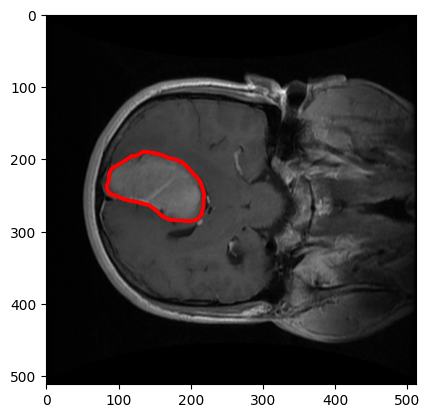

In [42]:
## Display a single image

import matplotlib.pyplot as plt

plt.imshow(images[0], cmap='gray')
plt.contour(masks[0], colors='r', linewidths=2)
plt.show()

# Step 4: Split the dataset into training, validation and test dataset

In [43]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(images_array, masks_array, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [44]:
print("x_train.shape: ", x_train.shape)
print("y_train.shape: ", y_train.shape)
print("x_val.shape: ", x_val.shape)
print("y_val.shape: ", y_val.shape)
print("x_test.shape: ", x_test.shape)
print("y_test.shape: ", y_test.shape)

x_train.shape:  (1960, 512, 512, 1)
y_train.shape:  (1960, 512, 512, 1)
x_val.shape:  (491, 512, 512, 1)
y_val.shape:  (491, 512, 512, 1)
x_test.shape:  (613, 512, 512, 1)
y_test.shape:  (613, 512, 512, 1)


# Step 5: Build the U-Net Segmentation Model

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, models

def unet_model(input_shape=(512, 512, 1)):
    """ Builds a U-Net model for tumor segmentation """

    inputs = layers.Input(shape=input_shape)

    # Encoder (Contracting Path)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation="relu", padding="same")(c5)

    # Decoder (Expanding Path)
    u6 = layers.UpSampling2D((2, 2))(c5)
    u6 = layers.concatenate([u6, c4])  # Skip connection
    c6 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(u6)
    c6 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c6)

    u7 = layers.UpSampling2D((2, 2))(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(u7)
    c7 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c7)

    u8 = layers.UpSampling2D((2, 2))(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u8)
    c8 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c8)

    u9 = layers.UpSampling2D((2, 2))(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u9)
    c9 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c9)

    # Output layer: 1 channel, sigmoid activation for binary segmentation
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c9)

    model = models.Model(inputs, outputs)
    return model

# Build and compile the model
unet_model = unet_model(input_shape=(512, 512, 1))
unet_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Print model summary
unet_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 512, 512, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 512, 512, 64)   │            640 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 512, 512, 64)   │         36,928 │ conv2d_48[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_18          │ (None, 256, 256, 64)   │              0 │ conv2d_49[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 256, 256, 128)  │         73,856 │ max_pooling2d_18[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 256, 256, 128)  │        147,584 │ conv2d_50[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_19          │ (None, 128, 128, 128)  │              0 │ conv2d_51[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 128, 128, 256)  │        295,168 │ max_pooling2d_19[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_53 (Conv2D)        │ (None, 128, 128, 256)  │        590,080 │ conv2d_52[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_20          │ (None, 64, 64, 256)    │              0 │ conv2d_53[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_54 (Conv2D)        │ (None, 64, 64, 512)    │      1,180,160 │ max_pooling2d_20[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 64, 64, 512)    │      2,359,808 │ conv2d_54[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_21          │ (None, 32, 32, 512)    │              0 │ conv2d_55[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 32, 32, 1024)   │      4,719,616 │ max_pooling2d_21[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 32, 32, 1024)   │      9,438,208 │ conv2d_56[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_8           │ (None, 64, 64, 1024)   │              0 │ conv2d_57[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8        

 Total params: 31,377,793 (119.70 MB)

 Trainable params: 31,377,793 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Train the U-Net model
unet_model.fit(x_train, y_train, epochs=5, batch_size=8, validation_data=(x_val, y_val))

Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 56s 186ms/step - accuracy: 0.9608 - loss: 4.0220 - val_accuracy: 0.9824 - val_loss: 0.0764
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 44s 178ms/step - accuracy: 0.9828 - loss: 0.0687 - val_accuracy: 0.9824 - val_loss: 0.0713
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 44s 178ms/step - accuracy: 0.9836 - loss: 0.0605 - val_accuracy: 0.9827 - val_loss: 0.0589
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 44s 178ms/step - accuracy: 0.9842 - loss: 0.0543 - val_accuracy: 0.9842 - val_loss: 0.0538
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 44s 178ms/step - accuracy: 0.9861 - loss: 0.0468 - val_accuracy: 0.9854 - val_loss: 0.0540


# Step 6: Build a Classification Model to determine the cancer type

In [47]:
print("images_array.shape:" , images_array.shape)
print("labels_array.shape: ", labels_array.shape)

images_array.shape: (3064, 512, 512, 1)
labels_array.shape:  (3064, 1)


In [48]:
labels_array = labels_array - 1

In [49]:
print(labels_array)

[[0]
 [1]
 [1]
 ...
 [2]
 [2]
 [2]]


In [50]:
x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(images_array, labels_array, test_size=0.2, random_state=42)
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(x_train_2, y_train_2, test_size=0.2, random_state=42)

In [60]:
## Build a CNN model to classify the tumor type

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(512, 512, 1)),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        # Change the MaxPooling layer to (1,2) to avoid negative dimension
        MaxPooling2D((1, 2)),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # 3 output classes
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create model
cnn_model = build_cnn_model()
cnn_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_72 (Conv2D)                   │ (None, 512, 512, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 512, 512, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_73 (Conv2D)                   │ (None, 256, 256, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_74 (Conv2D)                   │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_75 (Conv2D)                   │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_76 (Conv2D)                   │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 32, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │     134,218,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 256)                 │         131,3

 Total params: 135,954,819 (518.63 MB)

 Trainable params: 135,952,835 (518.62 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [61]:
cnn_model.fit(x_train_2, y_train_2, epochs=5, batch_size=8, validation_data=(x_val_2, y_val_2))

Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.5123 - loss: 60.2846 - val_accuracy: 0.4338 - val_loss: 25.3828
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7365 - loss: 17.3305 - val_accuracy: 0.6782 - val_loss: 2.7381
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7501 - loss: 6.4223 - val_accuracy: 0.4868 - val_loss: 2.7350
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7153 - loss: 6.1085 - val_accuracy: 0.7597 - val_loss: 0.6158
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.7549 - loss: 3.0069 - val_accuracy: 0.7760 - val_loss: 0.5270


In [65]:
## Predict the cancer type

predictions = cnn_model.predict(x_train_2)
predicted_labels = np.argmax(predictions, axis=1)

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [67]:
print(predicted_labels[0])
print(y_train_2[0])

if predicted_labels[0] == 0:
    print("Predicted: Meningioma")
elif predicted_labels[0] == 1:
    print("Predicted: Glioma")
elif predicted_labels[0] == 2:
    print("Predicted: Pituitary Tumor")

1
[1]
Predicted: Glioma


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


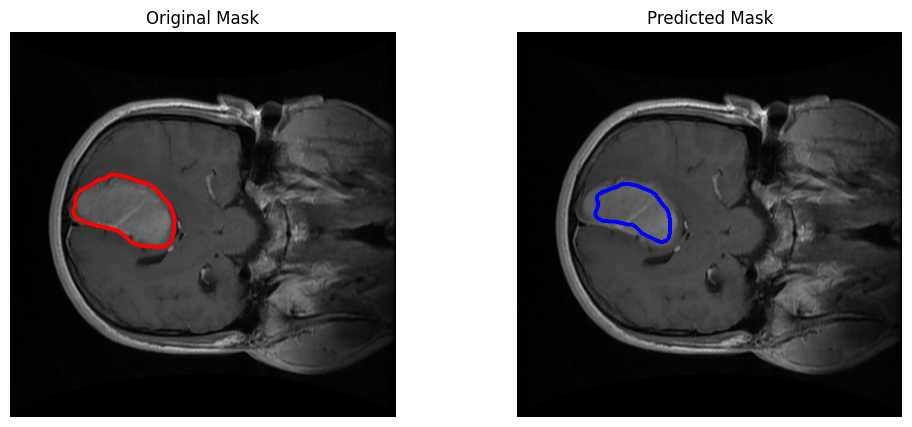

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# Select a test image (Ensure shape is (1, 512, 512, 1))
test_image = np.expand_dims(images_array[0], axis=0)  # Add batch dimension (1, 512, 512, 1)

# Make a prediction using the U-Net model (not the CNN model)
predicted_mask = unet_model.predict(test_image)  # Output shape: (1, 512, 512, 1)

# Convert predicted mask to binary (Threshold at 0.5)
binary_pred_mask = (predicted_mask[0] > 0.7).astype(np.uint8)  # Remove batch dim (512, 512, 1)
binary_pred_mask = np.squeeze(binary_pred_mask)  # Remove channel dimension (512, 512)

# Convert NumPy prediction to `cjdata` format
cjdata_predicted = {
    "image": images[0],       # Original MRI scan
    "tumorMask": binary_pred_mask  # Replace tumor mask with predicted mask
}

# Plot Original vs. Predicted Mask
plt.figure(figsize=(12, 5))

# Plot Original Image with True Mask
plt.subplot(1, 2, 1)
plt.imshow(images[0], cmap="gray")
plt.contour(masks[0], colors='r', linewidths=2)  # Red for original mask
plt.title("Original Mask")
plt.axis("off")

# Plot Original Image with Predicted Mask
plt.subplot(1, 2, 2)
plt.imshow(cjdata_predicted["image"], cmap="gray")
plt.contour(cjdata_predicted["tumorMask"], colors='b', linewidths=2)  # Blue for predicted mask
plt.title("Predicted Mask")
plt.axis("off")

plt.show()